<a href="https://colab.research.google.com/github/Kwannn666/AI-Interactive-Resume-Interview/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RAG 處理程式

將透過Perplexity pro所蒐集到的針對

(科技業公司 : 例如 :台積電，聯發科，聯詠，瑞昱，GOOGLE，群聯，慧榮，NVIDIA，高通不同職位等等)(來源為DCARD，PPT，公司網站介紹，面試心得分享)

相關資料整理成 : 一線公司RAG資料.docx

處理為 fauss_IC_db 供主程式 RAG 部分做使用

**重要補充 :**

**運行本專案需要 OpenAI API 金鑰設定**

為確保本 RAG 處理程式能完整運行所有功能，使用者需要設定一個有效的 OpenAI API 金鑰。請按照以下步驟操作：

1. 獲取金鑰： 如果您尚未擁有，請前往 OpenAI API Keys 頁面 登入並創建一個新的 Secret Key (sk-... 開頭)。

2. 在 Colab 中設定金鑰：

  a. 打開本專案的 Colab 連結。

  b. 在 Colab 介面左側，點擊鑰匙圖標 (Secrets / 秘密)。

  c. 點擊 + 新增密碼 (或 Add a new secret)。

  d. 在「名稱 (Name)」欄位中，輸入 OpenAI。（此名稱必須精確匹配，大小寫敏感）

  e. 在「值 (Value)」欄位中，貼上您從 OpenAI 獲取的 API 金鑰（例如 sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx）。

  f. 勾選下方的「在筆記本中顯示 (Notebook access)」選項。

4. 運行專案： 設定完成後，請依序執行 Colab 筆記本中的所有程式碼單元格。程式將自動從您的 Colab Secrets 中安全地載入金鑰。

**若未設定金鑰或金鑰無效，系統將無法調用 OpenAI 模型，RAG處理程式功能將無法運作。**

In [ ]:
import os
import zipfile # 壓縮檔案
!pip install -q langchain langchain-community pypdf python-docx unstructured faiss-cpu openai tiktoken

In [ ]:
# --- OpenAI API 金鑰設定 ---
from google.colab import userdata
from getpass import getpass
try:
    api_key = userdata.get('OpenAI')
    os.environ['OPENAI_API_KEY'] = api_key
    print("OpenAI API 金鑰已透過 Colab userdata 安全載入並設定完成！")
except Exception as e:
    if "OPENAI_API_KEY" not in os.environ:
        os.environ["OPENAI_API_KEY"] = getpass("從 Colab Secrets 獲取金鑰失敗，請手動輸入您的 OpenAI API 金鑰: ")
        if "OPENAI_API_KEY" not in os.environ:
             print("警告：OpenAI API 金鑰未設定，嵌入模型將無法初始化。")

OpenAI API 金鑰已透過 Colab userdata 安全載入並設定完成！


In [ ]:
# --- 設定資料上傳目錄 ---
upload_dir = "uploaded_dir"
os.makedirs(upload_dir, exist_ok=True)
print(f"請將您的 .txt, .pdf, .docx 檔案上傳到這個資料夾中： {upload_dir}")

請將您的 .txt, .pdf, .docx 檔案上傳到這個資料夾中： uploaded_dir


In [ ]:
# --- LangChain 組件 ---
from langchain_community.document_loaders import TextLoader, PyPDFLoader, UnstructuredWordDocumentLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings # 跟教授原始程式碼主要不同的進行更改地方：改用 OpenAIEmbeddings (E3)
from langchain.vectorstores import FAISS
from langchain_core.documents import Document

根據Gemini建議進行debug並且修正向量維度不匹配問題

=> 使用OpenAIEmbeddings(model="text-embedding-3-small")

替代

HuggingFaceEmbeddings 和 CustomE5Embedding

並微調程式語法

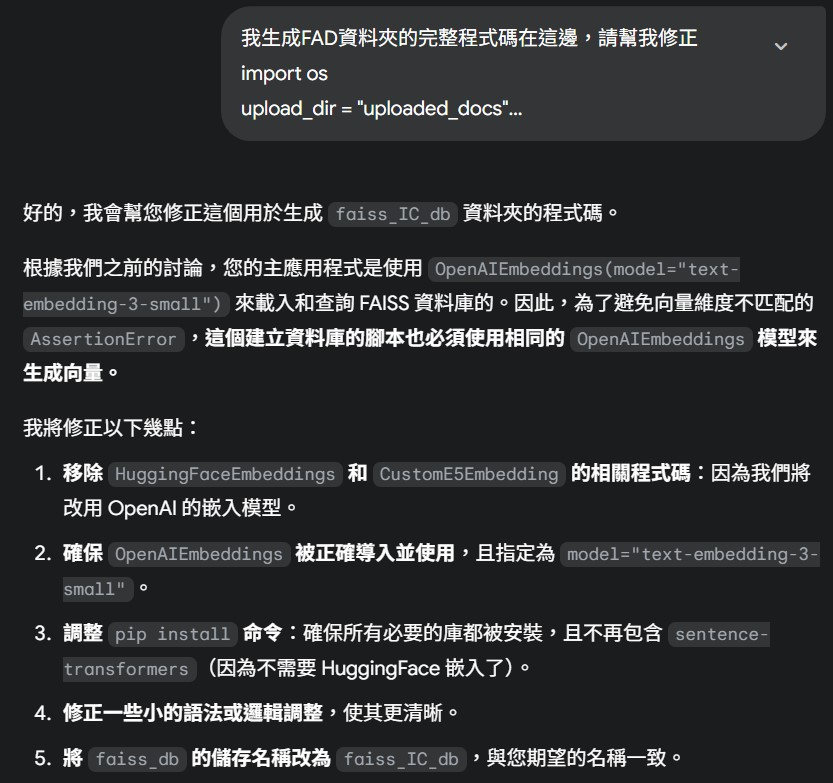

In [ ]:
# --- 載入文件 ---
documents = []
if not os.listdir(upload_dir):
    print(f"警告：'{upload_dir}' 資料夾為空。請上傳您的原始文件。")
for file_name in os.listdir(upload_dir):
    path = os.path.join(upload_dir, file_name)
    loader = None
    if file_name.endswith(".txt"):
        loader = TextLoader(path)
    elif file_name.endswith(".pdf"):
        loader = PyPDFLoader(path)
    elif file_name.endswith(".docx"):
        try:
            loader = UnstructuredWordDocumentLoader(path)
        except Exception as e:
            print(f"載入 Word 文件 {file_name} 失敗: {e}。")
            continue
    else:
        print(f"跳過不支援的文件類型: {file_name}")
        continue
    if loader:
        try:
            documents.extend(loader.load())
            print(f"已載入文件: {file_name}")
        except Exception as e:
            print(f"處理文件 {file_name} 時發生錯誤: {e}")

if not documents:
    print("沒找到可用檔案。")
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100) # 文件切割
split_docs = splitter.split_documents(documents)
print(f"文件已切割成 {len(split_docs)} 個塊。")

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small") # 定義模型
print("嵌入模型已設定為 'text-embedding-3-small'。")


已載入文件: 一線公司RAG資料.docx
文件已切割成 11 個塊。
嵌入模型已設定為 'text-embedding-3-small'。


In [ ]:
# --- 建立向量資料庫 ---
if split_docs:
    vectorstore = FAISS.from_documents(split_docs, embedding_model)
    print("向量資料庫已建立。")
    db_path = "faiss_IC_db"
    vectorstore.save_local(db_path)
    print(f"向量資料庫已儲存至 '{db_path}' 資料夾。")
    if os.path.exists(db_path) and os.path.isdir(db_path) and os.listdir(db_path):
        zip_file_name = f"{db_path}.zip"
        with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(db_path):
                for file in files:

                    zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), db_path))

        print(f"✅ 壓縮好的向量資料庫已儲存為 '{zip_file_name}'，請下載此檔案備份。")
        print(f"您現在可以在 Colab 的左側檔案瀏覽器中找到 '{zip_file_name}' 並下載。")
    else:
        print(f"警告：'{db_path}' 資料夾不存在或為空，無法進行壓縮。")
else:
    print("沒有文件塊可以建立向量資料庫。請檢查原始文件載入和切割是否成功。")

向量資料庫已建立。
向量資料庫已儲存至 'faiss_IC_db' 資料夾。
✅ 壓縮好的向量資料庫已儲存為 'faiss_IC_db.zip'，請下載此檔案備份。
您現在可以在 Colab 的左側檔案瀏覽器中找到 'faiss_IC_db.zip' 並下載。
